# Baseline Linear Regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df  = add_shift_raw_column(test_df, spo2_to_po2)
val_df   = add_shift_raw_column(val_df, spo2_to_po2)

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
features = ['PiO2(kPa)', 'SpO2(%)']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
test_summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(test_summary)


Macro-averaged per-patient metrics:
MAE  = 1.049
MSE  = 2.769
RMSE = 1.256
Mean Bias Error = 0.010
MAPE = 9.853%
nRMSE = 6.678%


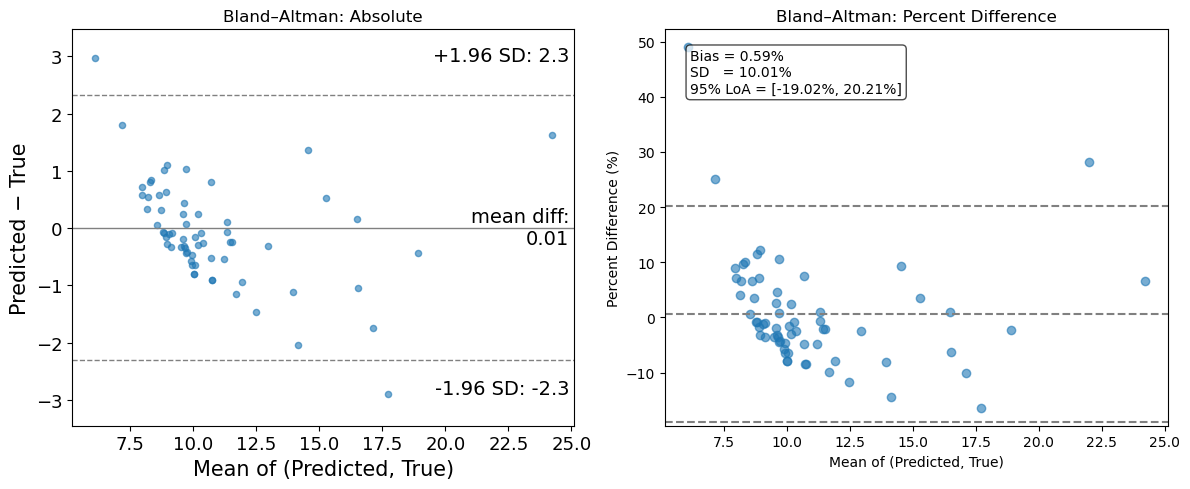

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [4]:
bland_altman_plots(test_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


Macro-averaged per-patient metrics:
MAE  = 1.225
MSE  = 3.936
RMSE = 1.528
Mean Bias Error = 0.277
MAPE = 10.096%
nRMSE = 7.835%


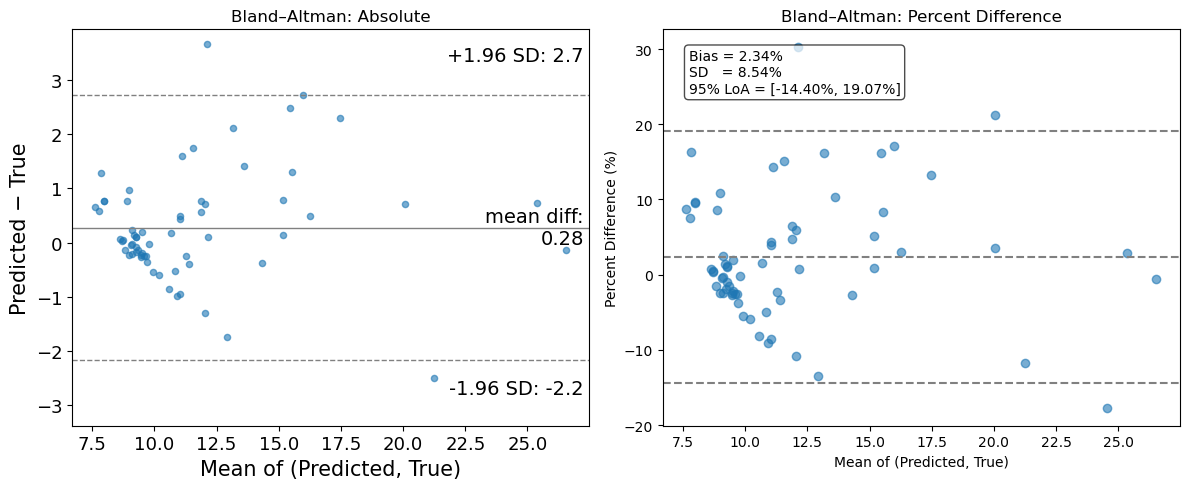

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [5]:
val_df['y_pred'] = predict_cv_ensemble(val_df, features, cv_models)

val_summary = evaluate_macro_patient_level(val_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(val_summary)

bland_altman_plots(val_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


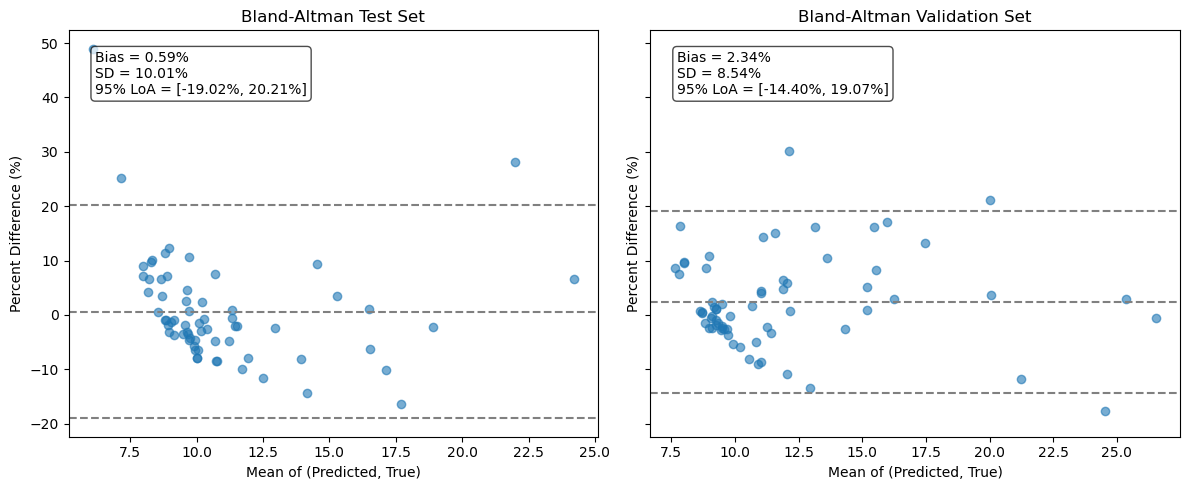

In [6]:
fig, axs = bland_altman_pct_comparison(test_df, val_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


In [7]:
description = f'''
Model: Linear Regression Baseline
Description: This model uses a linear regression approach to predict the shift in PiO2 based on the raw shift, PiO2, and SpO2 values. It is trained on a dataset of neonatal patients with ODC data.
Features: shift_raw, PiO2(kPa), SpO2(%)
Target: shift
Notes: patient-level macro metrics, ODC from neonatal table
'''

# Filter only scalar (JSON-serializable) entries
json_test_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in test_summary.items()
    if not isinstance(v, pd.Series)
}
json_val_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in val_summary.items()
    if not isinstance(v, pd.Series)
}

json_path = RESULTS_PATH / "single_point_model_metrics_log.json"

log_run_json(
    identifier="Linear Regression Baseline",
    model_type="Linear Regression",
    features=features,
    train_subset="full train set",
    test_subset="full test set",
    val_subset="full validation set",  
    description=description,
    test_metrics=json_test_metrics,
    val_metrics=json_val_metrics,

    json_path=json_path
)


✅ Logged run #1 ➜ /Users/sarah/Code/neonatal-odc-shift/results/single_point_model_metrics_log.json
